# <center> FSAN/ELEG815 Analytics I: Statistical Learning <center>
# <center> Homework #2, Fall 2024 <center>
## <center> written by Chenchuan He <center>

## Question 1. 

Write a function to perform KNN (K nearest neighbors) classification in
2D based on the Euclidean distance metric. The function should receive
as parameters the data Matrix, containing the points and the class of each
point, the query matrix, containing the coordinates of the points you wish
to classify, and the number of neighbors. The output should be the classes
for each of the query points. Test your code for the attached data given
in “H3Data.mat” with $k = 3$

In [1]:
# read data "hw2/Data/H3Data.mat"
# !pip install scipy
# !pip install numpy
# !pip install matplotlib
import numpy as np
import scipy.io
data = scipy.io.loadmat('Data/H3Data.mat')

In [2]:
data['Datamat'].shape, data['Querymat'].shape

((100, 3), (20, 2))

In [3]:
def KNN(Datamat, Querymat, k, distance_type = 'euclidean'):
    # Datamat: n*d, Querymat: m*d
    data_coordinates = Datamat[:,:2]
    data_labels = Datamat[:,2]
    # ensure the labels are integers
    data_labels = data_labels.astype(int)

    query_coordinates = Querymat[:,:2]

    predicted_query_labels = []

    for query_data_point in query_coordinates:
        # calculate the distance between the query data point and all the data_coordinates
        distances = np.linalg.norm(data_coordinates - query_data_point, axis=1)
        # sort indices of distances and get the k nearest labels
        sorted_indices = np.argsort(distances)
        k_nearest_labels = data_labels[sorted_indices[:k]]
        # get the most frequent label
        most_frequent_label = int(np.argmax(np.bincount(k_nearest_labels)))
        # add to the predicted_query_labels
        predicted_query_labels.append(most_frequent_label)

    return predicted_query_labels

In [4]:
datamat = data['Datamat']
querymat = data['Querymat']
k = 3
predicted_query_labels = KNN(datamat, querymat, k)
print(predicted_query_labels)

[3, 1, 2, 1, 2, 1, 1, 1, 3, 2, 3, 1, 1, 3, 3, 3, 1, 3, 2, 2]


Text(0.5, 1.0, 'Query Result')

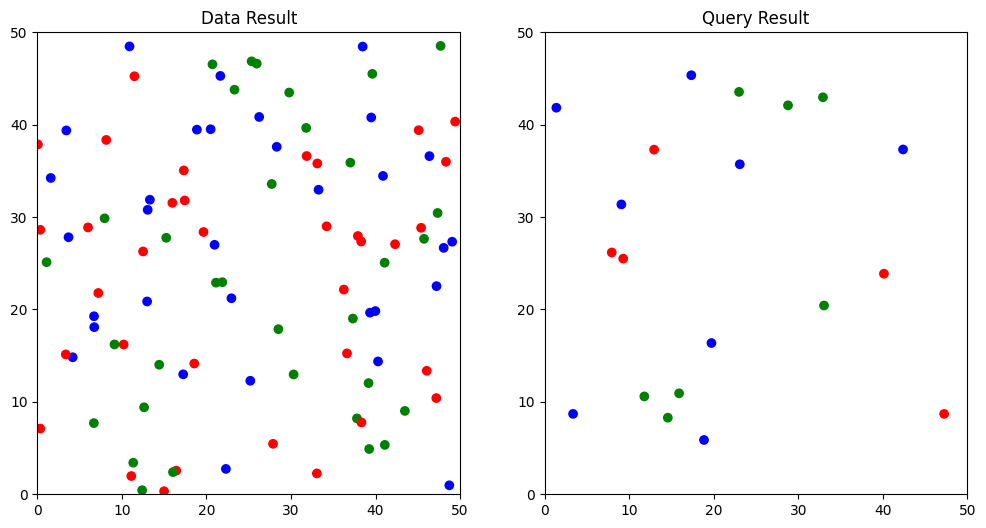

In [5]:
# plot the test data results
import matplotlib.pyplot as plt
# plot in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# use the same color for both plots, i.e. the labels with 0 to be blue, 1 to be yellow, 2 to be green
colors = np.array(['blue', 'red', 'green'])

# plot the data
axs[0].scatter(datamat[:,0], datamat[:,1], c=colors[datamat[:, 2].astype(int)-1])
# set x and y axis lengths to be both 50
axs[0].set_xlim([0, 50])
axs[0].set_ylim([0, 50])
axs[0].set_title('Data Result')

# plot the query
axs[1].scatter(querymat[:,0], querymat[:,1], c=colors[[int(x)-1 for x in predicted_query_labels]])
# set x and y axis lengths to be both 50
axs[1].set_xlim([0, 50])
axs[1].set_ylim([0, 50])
axs[1].set_title('Query Result')

# Question 2.

Apply K-means to image compression. In an RGB image, each pixel is
represented as three 8-bit integer (ranging from 0 to 255) that specify the
red, green and blue intensity values. An image contains many different
colors. Use the K-means algorithm to find a compressed version of the
original image “Image.png”. Treat every pixel in the original image as a 3-
dimensional data example and use K-means algorithm to find the K colors
that best cluster all the pixels in the 3-dimensional RGB image. Next, use
the obtained K colors to replace the pixels in the original image. Repeat
the experiment for $K=10$ and $K=20$, report your results and conclusions.
You can define your own threshold.

In [6]:
# read the .png file as a RGB arrary, with each pixel represented as three 8-bit integer (ranging from 0 to 255) that specify the red, green and blue intensity values.
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = Image.open('Data/Image.png')
# Convert the image to RGB mode (in case it is not)
image = image.convert('RGB')
# Convert the image to a NumPy array
pixels = np.array(image)
# Flatten the image to get each pixel's RGB values
h, w, c = pixels.shape
pixels = pixels.reshape((h*w, c))

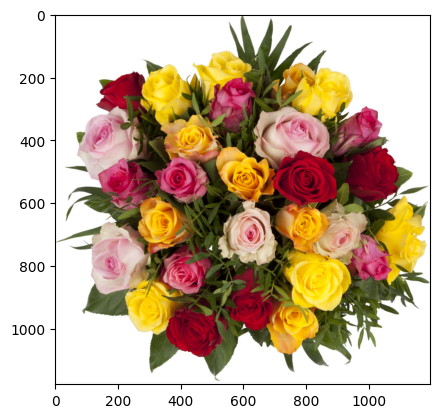

In [7]:
# show original image here
plt.imshow(image)

In [8]:
pixels.shape, pixels[0]

((1406515, 3), array([255, 255, 255], dtype=uint8))

In [9]:
def load_preprocess_image(img_path):
    image = Image.open(img_path)
    image = image.convert('RGB')
    pixels = np.array(image)
    h, w, c = pixels.shape
    pixels = pixels.reshape((h*w, c))
    return pixels, h, w

def reload_image(centroids, labels, h, w):
    compressed_pixels = centroids[labels].astype(np.uint8)
    compressed_img = compressed_pixels.reshape(h, w, 3)
    return compressed_img

In [10]:
# Initialize K random centroids
def initialize_centroids(pixels, K):
    indices = np.random.choice(pixels.shape[0], K, replace=False)
    centroids = pixels[indices]
    return centroids

# Assign each pixel to the nearest centroid
def assign_clusters(pixels, centroids):
    distances = np.sqrt(((pixels - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update the centroids by computing the mean of all pixels in each cluster
def update_centroids(pixels, labels, K):
    new_centroids = []
    for k in range(K):
        if np.any(labels == k):  # Check if there are any points assigned to the cluster
            new_centroids.append(pixels[labels == k].mean(axis=0))
        else:
            # If no points are assigned to this cluster, reinitialize the centroid randomly
            new_centroids.append(pixels[np.random.choice(pixels.shape[0])])
    return np.array(new_centroids)

# k-means algorithm function
def k_means(pixels, K, max_iters=100, threshold=1e-5):
    centroids = initialize_centroids(pixels, K)
    iteration_info = {}
    for i in range(max_iters):
        labels = assign_clusters(pixels, centroids)
        new_centroids = update_centroids(pixels, labels, K)
        # compute the difference between the old and new centroids
        centroids_diff = np.linalg.norm(new_centroids - centroids)
        # store the iteration number and the centroids difference
        iteration_info[i] = centroids_diff
        # print(f'iteration {i+1}, centroids_diff: {centroids_diff}')
        if centroids_diff < threshold:
            break
        centroids = new_centroids
    return centroids, labels, iteration_info

# main function for the image compression
def compress_image(image_path, K, max_iters=100, threshold=1):
    pixels, h, w = load_preprocess_image(image_path)
    centroids, labels, iteration_info = k_means(pixels, K, max_iters, threshold)
    compressed_img = reload_image(centroids, labels, h, w)
    return compressed_img, iteration_info

In [11]:
K_list = [10,20]
experiment_rounds = 5
experiment_records = {}

for round in range(experiment_rounds):
    interation_info_full = {}
    compressed_imgs = {}
    for K in K_list:
        compressed_img, iteration_info = compress_image('Data/Image.png', K, max_iters=100, threshold=1e-3)
        compressed_imgs[K] = compressed_img
        interation_info_full[K] = iteration_info
        #plt.imshow(compressed_img)
        #plt.title(f'K={K}')
        #plt.show()
    experiment_records[round] = (compressed_imgs, interation_info_full)

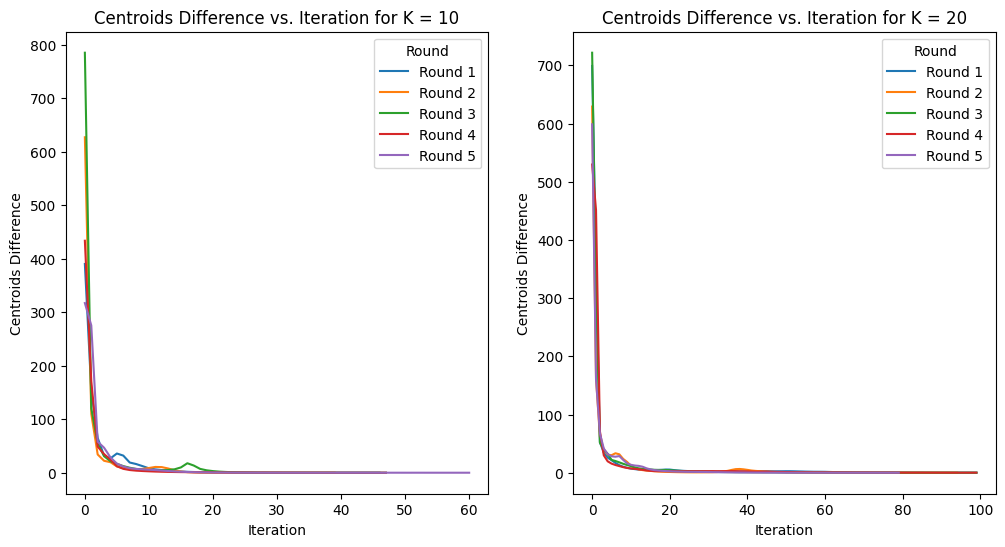

In [12]:
# plot the iteration information for each K with each round
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, K in enumerate(K_list):
    for round in range(experiment_rounds):
        # plot the iteration information of one K, different rounds in one subplot
        iteration_info = experiment_records[round][1][K]
        axs[i].plot(list(iteration_info.keys()), list(iteration_info.values()), label=f'K={K}')
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel('Centroids Difference')
        axs[i].set_title(f'Centroids Difference vs. Iteration for K = {K}')
        # set the legend for the subplot by round
        axs[i].legend(title='Round', 
                      labels = [f'Round {round+1}' for round in range(experiment_rounds)])
plt.show()

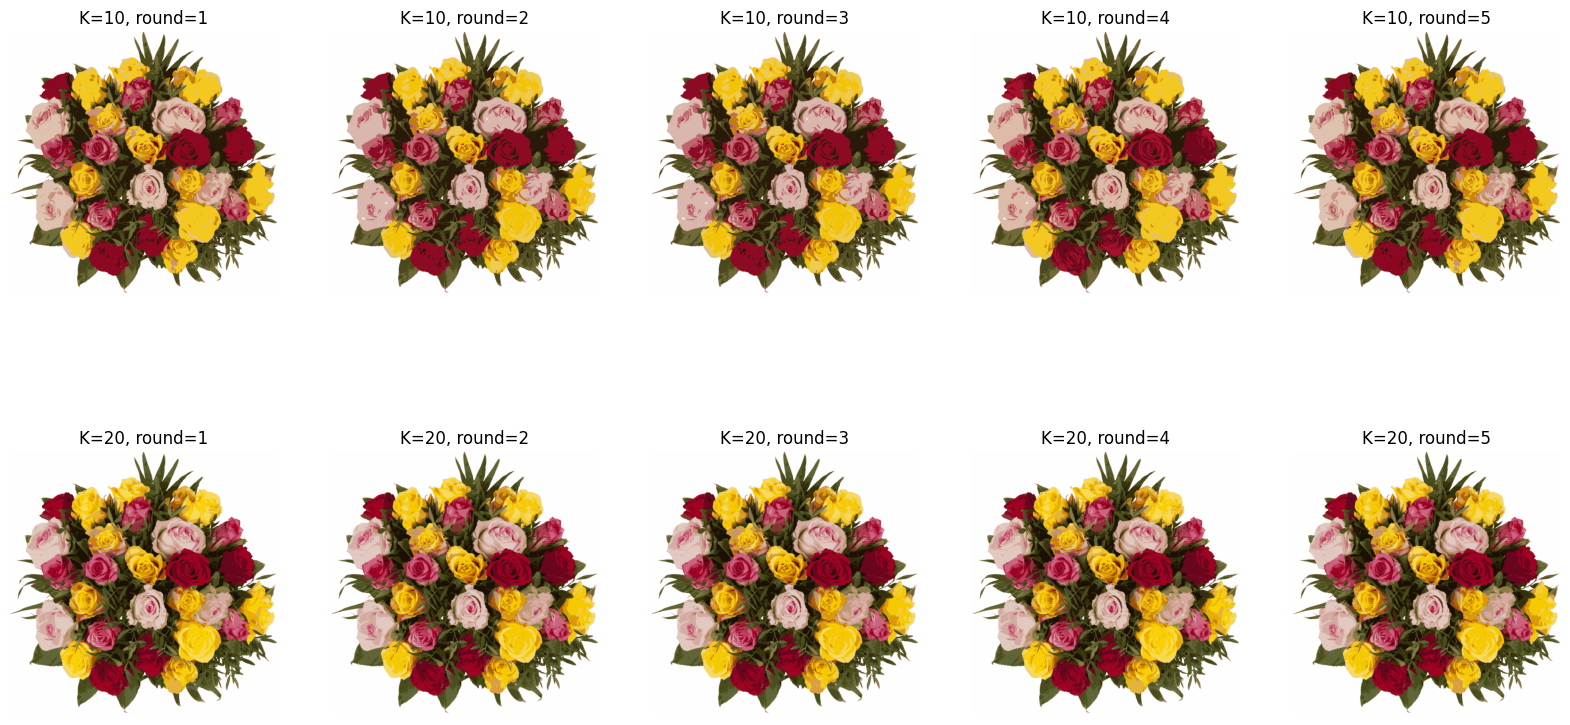

In [13]:
# show pictures of the compressed images with K=10 and K=20 in each round in 2*5 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for round in range(experiment_rounds):
    for i, K in enumerate(K_list):
        compressed_img = experiment_records[round][0][K]
        axs[i, round].imshow(compressed_img)
        axs[i, round].set_title(f'K={K}, round={round+1}')
        axs[i, round].axis('off')

## Conclusion:

The larger K creates a better image after compressing.

The convergence speed of K=10 and K=20 does not vary much, both of them converges after around 10 iterations.

# Question 3.

Handwritten Digit Recognition. The goal is to recognize the digit in each image of the dataset given in “DigitsTraining” which contains some digits from the US Postal Service Zip Code. We are going to decompose the big task of separating ten digits into smaller tasks of separating two of the digits (binary classification). Use two digits: the final number in your UD ID and conveniently choose any other number to replicate the results from the slides chapter “The Learning Problem” (take into account the features that you are going to use for classification to choose the second number).


Dataset description: The first column in DigitsTraining and DigitsTesting corresponds to the digit number, following columns correspond to 256 pixels of the 16 × 16 pixel image of the digit. Thus, we have 7291 inputs in DigitsTraining and 2007 inputs in DigitsTesting. From these datasets, work only with those inputs that correspond to the digits you chose. Remember, one of the digits corresponds to the final number in your UD ID.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
udid = '702777403'
other_number = 6
digits = [int(udid[-1]), other_number]
digits

[3, 6]

In [3]:
train_data_path = "Data/DigitsTraining.csv"
test_data_path = "Data/DigitsTesting.csv"
train_data = np.genfromtxt(train_data_path, delimiter=',')
# extract the first column as it is label
train_labels = train_data[:,0]
# extract the rest columns as it is features
train_features = train_data[:,1:]
# train_data = (train_labels, train_features)

test_data = np.genfromtxt(test_data_path, delimiter=',')
# extract the first column as it is label
test_labels = test_data[:,0]
# extract the rest columns as it is features
test_features = test_data[:,1:]
# test_data = (test_labels, test_features)

# only keep digits 3 and 6, i.e. label in digits
train_indices = np.isin(train_labels, digits)
test_indices = np.isin(test_labels, digits)

train_labels = train_labels[train_indices]
train_features = train_features[train_indices]
test_labels = test_labels[test_indices]
test_features = test_features[test_indices]

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((1322, 256), (336, 256), (1322,), (336,))

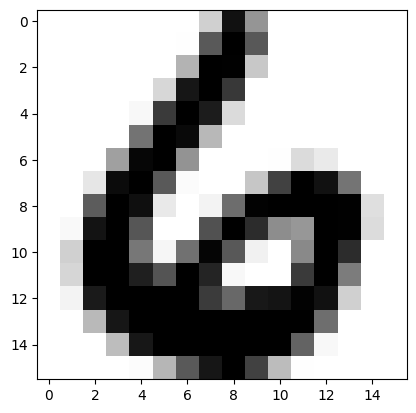

In [4]:
# plot one example from train_data
plt.imshow(train_features[0, :].reshape(16, 16), cmap='gray')

## (a) 

Extract 2 features from the images: average intensity and symmetry. Using this two features, implement the Perceptron Learning Algorithm. Use an error metric for binary classification. To compute $E_{out}$, use the testing set given to you in “DigitsTesting”. Show only 200 iterations.

In [5]:
def cal_avg_intensity(single_digit):
    return np.mean(single_digit)

def cal_symmetry(single_digit):
    # reshape the single_digit to 16*16
    single_digit = single_digit.reshape(16, 16)
    vertical_symmetry = np.mean(np.abs(single_digit - np.flip(single_digit, axis=0)))
    horizontal_symmetry = np.mean(np.abs(single_digit - np.flip(single_digit, axis=1)))
    return (vertical_symmetry + horizontal_symmetry) / 2

In [6]:
# use intensity and symmetry as features, to create a matrix of features X_train
X_train = np.zeros((train_features.shape[0], 2))
X_train[:, 0] = np.apply_along_axis(cal_avg_intensity, 1, train_features)
X_train[:, 1] = np.apply_along_axis(cal_symmetry, 1, train_features)
# also for X_test
X_test = np.zeros((test_features.shape[0], 2))
X_test[:, 0] = np.apply_along_axis(cal_avg_intensity, 1, test_features)
X_test[:, 1] = np.apply_along_axis(cal_symmetry, 1, test_features)

In [7]:
import numpy as np
from tqdm import tqdm

class Perceptron:
    def __init__(self, learning_rate=0.01, max_iters=200, 
                 X_train=None, y_train=None, X_test=None, y_test=None, 
                 digits=None):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.weights = None
        self.bias = None
        self.in_sample_errors = []
        self.out_of_sample_errors = []
        self.digits = digits
        self.X_train = X_train
        self.y_train = [self.modify_label_to_binary(label) for label in y_train] if y_train is not None else None
        self.X_test = X_test
        self.y_test = [self.modify_label_to_binary(label) for label in y_test] if y_test is not None else None

    
    def fit_PLA(self):
        
        n_samples, n_features = self.X_train.shape
        # start with zeros
        self.weights = np.zeros(n_features)
        self.bias = 0
        # track the iteration process
        for _ in tqdm(range(self.max_iters)):
            errors_in_iteration = 0  # Track errors in this iteration
            
            for idx, x_i in enumerate(self.X_train):
                linear_output = self.predict(self.X_train[idx])
                # update the weights and bias if the prediction is wrong
                if self.y_train[idx] * linear_output <= 0:
                    self.weights += self.learning_rate * self.y_train[idx] * x_i
                    self.bias += self.learning_rate * self.y_train[idx]
                    errors_in_iteration += 1  # Count misclassifications
                
            # save the in-sample error and out-of-sample error for each iteration
            in_sample_error = self.cal_error(self.X_train, self.y_train)
            out_of_sample_error = self.cal_error(self.X_test, self.y_test)
            self.in_sample_errors.append(in_sample_error)
            self.out_of_sample_errors.append(out_of_sample_error)
            
            # Early stopping if no errors in this iteration
            if errors_in_iteration == 0:
                break

    def fit_pocket(self):
        n_samples, n_features = self.X_train.shape
        # initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # store the best weights, bias, and error
        best_weights = self.weights.copy()
        best_bias = self.bias
        best_error = self.cal_error(self.X_train, self.y_train)
        
        # track the iteration process with tqdm
        for _ in tqdm(range(self.max_iters)):
            errors_in_iteration = 0
            
            for idx, x_i in enumerate(self.X_train):
                linear_output = self.predict(self.X_train[idx])
                # update the weights and bias if the prediction is wrong
                if self.y_train[idx] * linear_output <= 0:
                    self.weights += self.learning_rate * self.y_train[idx] * x_i
                    self.bias += self.learning_rate * self.y_train[idx]
                    errors_in_iteration += 1
                    
                    # calculate the in-sample error after the update
                    current_error = self.cal_error(self.X_train, self.y_train)
                    
                    # if current error is better than the best error, update the best solution
                    if current_error < best_error:
                        best_error = current_error
                        best_weights = self.weights.copy()
                        best_bias = self.bias
            
            # save in-sample and out-of-sample errors for each iteration
            in_sample_error = best_error
            # calculate the out-of-sample error with the best found solution
            out_sample_error = 0
            for idx, x_i in enumerate(self.X_test):
                linear_output = np.dot(self.X_test[idx], best_weights) + best_bias
                if self.y_test[idx] * linear_output <= 0:
                    out_sample_error += 1
            out_sample_error /= len(self.X_test)

            self.in_sample_errors.append(in_sample_error)
            self.out_of_sample_errors.append(out_sample_error)
            # Early stopping if no errors in this iteration
            if errors_in_iteration == 0:
                break
        
        # After training, set the weights and bias to the best found solution
        self.weights = best_weights
        self.bias = best_bias
 

    def predict(self, X):
        pre = np.dot(X, self.weights) + self.bias
        if pre >= 0:
            return 1
        else:
            return -1
    
    def cal_error(self, X, y):
        n_samples = X.shape[0]
        error = 0
        for idx, x_i in enumerate(X):
            linear_output = self.predict(X[idx])
            if y[idx] * linear_output <= 0:
                error += 1
        return error / n_samples
    
    def modify_label_to_binary(self, label):
        if int(label) == int(self.digits[0]):
            return 1
        else:
            return -1

In [19]:
PLA = Perceptron(learning_rate=0.01, max_iters=200,
                        X_train=X_train, y_train=train_labels, 
                        X_test=X_test, y_test=test_labels, 
                        digits=digits)

# train the perceptrons
PLA.fit_PLA()


100%|██████████| 200/200 [00:00<00:00, 321.18it/s]


In [9]:
# calculate the error 
error_PLA = PLA.out_of_sample_errors[-1]
print(f'PLA out-of-sample error: {error_PLA}')

PLA out-of-sample error: 0.5059523809523809


## (b) 

Repeat item (a), for the pocket algorithm. Show the same plots that are in Slide 32 and 33 of the chapter “The Learning Problem”, that is, compare errors (Ein,Eout) and classification boundaries of the simple perceptron and the pocket algorithms. 4 images are expected.


In [10]:
Pocket = Perceptron(learning_rate=0.01, max_iters=200,
                        X_train=X_train, y_train=train_labels, 
                        X_test=X_test, y_test=test_labels, 
                        digits=digits)

# train the perceptrons
Pocket.fit_pocket()

100%|██████████| 200/200 [01:41<00:00,  1.96it/s]


In [11]:
error_Pocket = Pocket.out_of_sample_errors[-1]
print(f'Pocket out-of-sample error: {error_Pocket}')

Pocket out-of-sample error: 0.2857142857142857


In [12]:
-PLA.weights[0]

0.08141591796874358

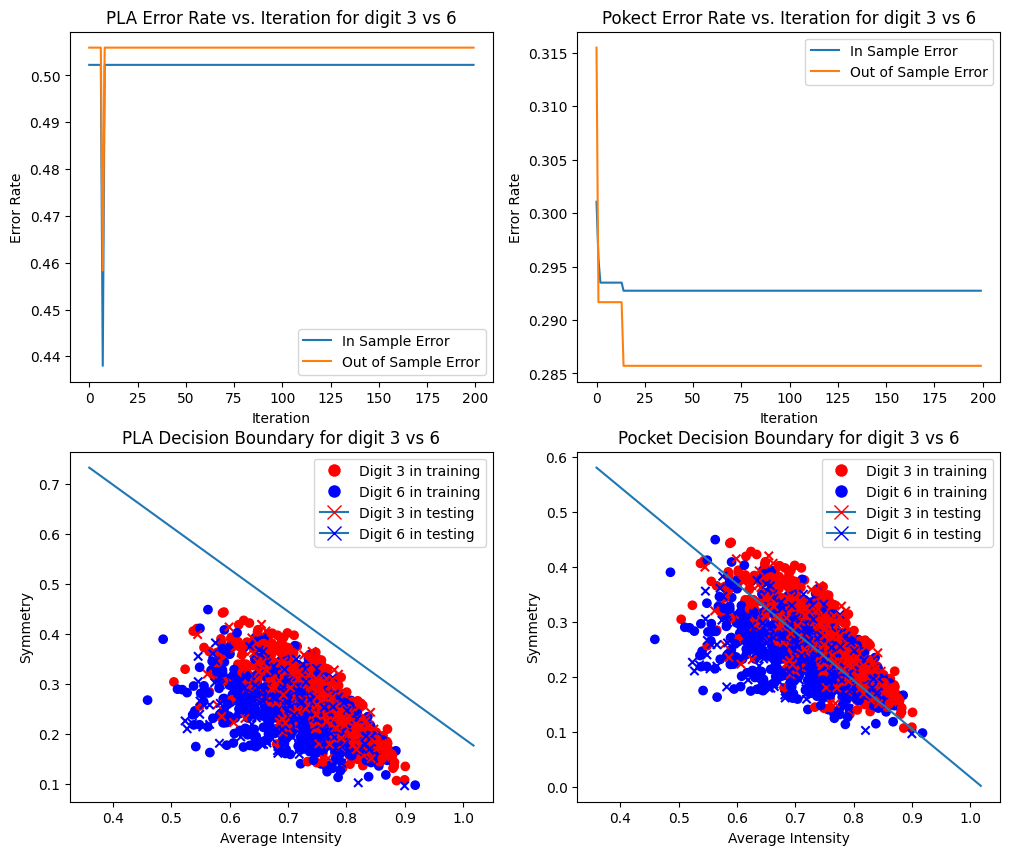

In [13]:
# 2*2 subplots 
plt.figure(figsize=(12, 10))
# the first subplot is the error rate vs. iteration of PLA
plt.subplot(2, 2, 1)
# plot the in sample error and out of sample error for each iteration, with x-axis as iteration number in one same plot
plt.plot(range(PLA.max_iters), PLA.in_sample_errors, label='In Sample Error')
plt.plot(range(PLA.max_iters), PLA.out_of_sample_errors, label='Out of Sample Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title(f'PLA Error Rate vs. Iteration for digit {digits[0]} vs {digits[1]}')
plt.legend()

# the second subplot is the error rate vs. iteration of Pocket
plt.subplot(2, 2, 2)
# plot the in sample error and out of sample error for each iteration, with x-axis as iteration number in one same plot
plt.plot(range(Pocket.max_iters), Pocket.in_sample_errors, label='In Sample Error')
plt.plot(range(Pocket.max_iters), Pocket.out_of_sample_errors, label='Out of Sample Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title(f'Pokect Error Rate vs. Iteration for digit {digits[0]} vs {digits[1]}')
plt.legend()


# the third subplot is the decision boundary of PLA
plt.subplot(2, 2, 3)
# plot the decision boundary
x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
boundary_x = np.array([x_min, x_max])
boundary_y = (-PLA.weights[0] * boundary_x - PLA.bias) / PLA.weights[1]
plt.plot(boundary_x, boundary_y, label='Decision Boundary')

# set colors for the two classes
colors = ['red', 'blue']
# plot the training data as circles
plt.scatter(X_train[:, 0], X_train[:, 1], c=[colors[int(x == digits[0])] for x in train_labels])
# plot the testing data as crosses
plt.scatter(X_test[:, 0], X_test[:, 1], marker='x', c=[colors[int(x == digits[0])] for x in test_labels])
plt.xlabel('Average Intensity')
plt.ylabel('Symmetry')
plt.title(f'PLA Decision Boundary for digit {digits[0]} vs {digits[1]}')
# also add legend of the two classes, digit 3 and digit 6
# update legend to include marker edge color and proper marker types
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Digit {digits[0]} in training'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=f'Digit {digits[1]} in training'),
        plt.Line2D([0], [0], marker='x', markeredgecolor='red', markersize=10, label=f'Digit {digits[0]} in testing'),
        plt.Line2D([0], [0], marker='x', markeredgecolor='blue', markersize=10, label=f'Digit {digits[1]} in testing')
    ]
)

# the fourth subplot is the decision boundary of Pocket
plt.subplot(2, 2, 4)
# plot the decision boundary
# the decision boundary is the line that the dot product of the weights and the features plus the bias is 0
x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
boundary_x = np.array([x_min, x_max])
boundary_y = (-Pocket.weights[0] * boundary_x - Pocket.bias) / Pocket.weights[1]
plt.plot(boundary_x, boundary_y, label='Decision Boundary')
# set colors for the two classes
colors = ['red', 'blue']
# plot the training data as circles
plt.scatter(X_train[:, 0], X_train[:, 1], c=[colors[int(x == digits[0])] for x in train_labels])
# plot the testing data as crosses
plt.scatter(X_test[:, 0], X_test[:, 1], marker='x', c=[colors[int(x == digits[0])] for x in test_labels])
plt.xlabel('Average Intensity')
plt.ylabel('Symmetry')
plt.title(f'Pocket Decision Boundary for digit {digits[0]} vs {digits[1]}')
# update legend to include marker edge color and proper marker types
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Digit {digits[0]} in training'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=f'Digit {digits[1]} in training'),
        plt.Line2D([0], [0], marker='x', markeredgecolor='red', markersize=10, label=f'Digit {digits[0]} in testing'),
        plt.Line2D([0], [0], marker='x', markeredgecolor='blue', markersize=10, label=f'Digit {digits[1]} in testing')
    ]
)

The result shows PLA does not learn anything from the two features. While Pocket learns some of the differences.

## (c) 
Extract one more feature from the images that could help to improve your previous results. Describe how you compute this feature and why is it representative of your data?.

In [14]:
# create a new feature for hand-written digit recognition, the left-right intensity difference
def cal_left_right_intensity_diff(single_digit):
    single_digit = single_digit.reshape(16, 16)
    left_intensity = np.mean(single_digit[:, :8])
    right_intensity = np.mean(single_digit[:, 8:])
    return left_intensity - right_intensity

# create new column for the new feature
X_train_new = np.zeros((train_features.shape[0], 3))
X_train_new[:, 0] = np.apply_along_axis(cal_avg_intensity, 1, train_features)
X_train_new[:, 1] = np.apply_along_axis(cal_symmetry, 1, train_features)
X_train_new[:, 2] = np.apply_along_axis(cal_left_right_intensity_diff, 1, train_features)

X_test_new = np.zeros((test_features.shape[0], 3))
X_test_new[:, 0] = np.apply_along_axis(cal_avg_intensity, 1, test_features)
X_test_new[:, 1] = np.apply_along_axis(cal_symmetry, 1, test_features)
X_test_new[:, 2] = np.apply_along_axis(cal_left_right_intensity_diff, 1, test_features)


To split 3 & 6, we can compute the left and right intensity difference, because 3 has more intensity in right and 6 will have more intensity in left. The attribute is computed by spiltting the image from middle, then compute the density of left and right half respectively, and finally use the left part intensity to minus the right intensity. Special note: never add absolute value when doing the subtraction, or the feature would be useless.

## (d) 

Repeat items (a) and (b), using the three features (average intensity, symmetry and the one that you choose in (c)). Hint: The classification boundary would be a plane given a 3D feature space. 

In [15]:
# train the perceptrons with the new feature
PLA_new = Perceptron(learning_rate=0.01, max_iters=200,
                        X_train=X_train_new, y_train=train_labels, 
                        X_test=X_test_new, y_test=test_labels, 
                        digits=digits)
PLA_new.fit_PLA()

100%|██████████| 200/200 [00:00<00:00, 375.73it/s]


In [16]:
Pocket_new = Perceptron(learning_rate=0.01, max_iters=200,
                        X_train=X_train_new, y_train=train_labels, 
                        X_test=X_test_new, y_test=test_labels, 
                        digits=digits)

Pocket_new.fit_pocket()

100%|██████████| 200/200 [00:16<00:00, 12.05it/s]


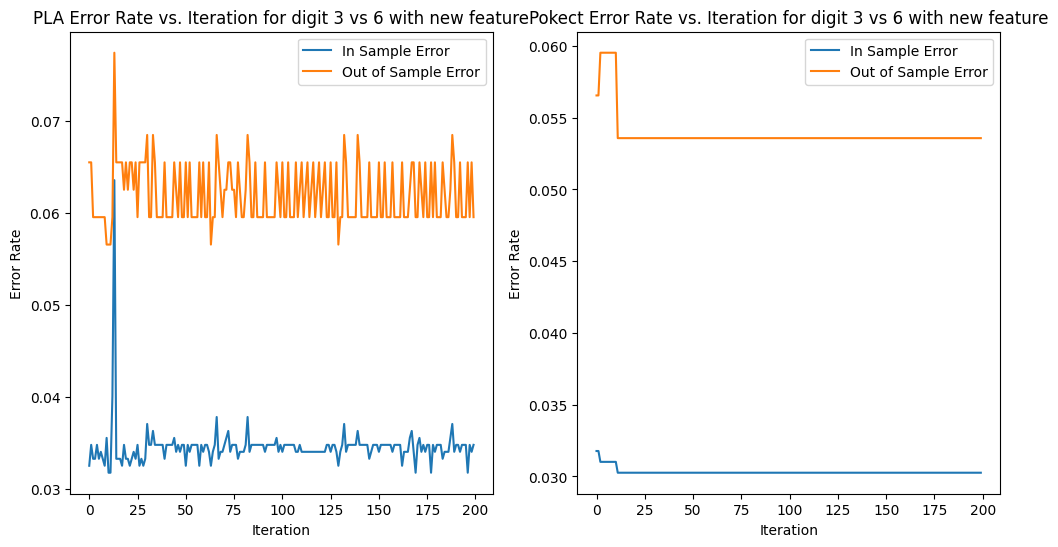

In [17]:
# 1*2 plot the error rate vs. iteration of PLA and Pocket with the new feature
plt.figure(figsize=(12, 6))
# the first subplot is the error rate vs. iteration of PLA with the new feature
plt.subplot(1, 2, 1)
# plot the in sample error and out of sample error for each iteration, with x-axis as iteration number in one same plot
plt.plot(range(PLA_new.max_iters), PLA_new.in_sample_errors, label='In Sample Error')
plt.plot(range(PLA_new.max_iters), PLA_new.out_of_sample_errors, label='Out of Sample Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title(f'PLA Error Rate vs. Iteration for digit {digits[0]} vs {digits[1]} with new feature')
plt.legend()

# the second subplot is the error rate vs. iteration of Pocket with the new feature
plt.subplot(1, 2, 2)
# plot the in sample error and out of sample error for each iteration, with x-axis as iteration number in one same plot
plt.plot(range(Pocket_new.max_iters), Pocket_new.in_sample_errors, label='In Sample Error')
plt.plot(range(Pocket_new.max_iters), Pocket_new.out_of_sample_errors, label='Out of Sample Error')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.title(f'Pokect Error Rate vs. Iteration for digit {digits[0]} vs {digits[1]} with new feature')
plt.legend()

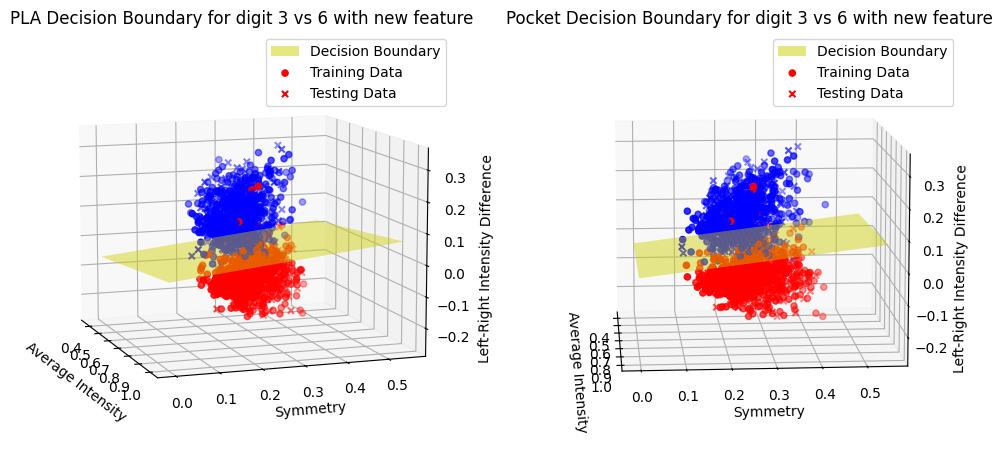

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate the best view based on the normal vector of the plane
def calculate_best_view(weights):
    # weights correspond to the normal vector (a, b, c) of the plane ax + by + cz + d = 0
    normal_vector = np.array(weights)
    
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Calculate the azimuthal angle (in degrees) perpendicular to the normal vector in the xy-plane
    azimuth = np.degrees(np.arctan2(normal_vector[1], normal_vector[0])) + 90  # Rotate 90 degrees to make it parallel
    
    # Set the elevation to 0 to look along the plane, or adjust based on preference
    elevation = 0  # Viewing parallel to the decision boundary, no tilt
    
    return azimuth+10, elevation+10

# Create a figure for 1x2 plots
fig = plt.figure(figsize=(12, 6))
# First subplot for the PLA decision boundary with the new feature
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Set the limits for the plot
x_min, x_max = X_train_new[:, 0].min() - 0.1, X_train_new[:, 0].max() + 0.1
y_min, y_max = X_train_new[:, 1].min() - 0.1, X_train_new[:, 1].max() + 0.1
z_min, z_max = X_train_new[:, 2].min() - 0.1, X_train_new[:, 2].max() + 0.1
# Create meshgrid for the decision boundary
boundary_x = np.linspace(x_min, x_max, 50)
boundary_y = np.linspace(y_min, y_max, 50)
boundary_x, boundary_y = np.meshgrid(boundary_x, boundary_y)
# Compute boundary_z based on the plane equation (weights * features + bias = 0)
boundary_z = (-PLA_new.weights[0] * boundary_x - PLA_new.weights[1] * boundary_y - PLA_new.bias) / PLA_new.weights[2]
# Plot the decision boundary (the plane)
ax.plot_surface(boundary_x, boundary_y, boundary_z, alpha=0.5, color='yellow', label='Decision Boundary')

# Set colors for the two classes
colors = ['red', 'blue']
# Plot the training data as circles in 3D
train_colors = [colors[int(x == digits[0])] for x in train_labels]
ax.scatter(X_train_new[:, 0], X_train_new[:, 1], X_train_new[:, 2], c=train_colors, marker='o', label='Training Data')
# Plot the testing data as crosses in 3D
test_colors = [colors[int(x == digits[0])] for x in test_labels]
ax.scatter(X_test_new[:, 0], X_test_new[:, 1], X_test_new[:, 2], c=test_colors, marker='x', label='Testing Data')

# Label axes
ax.set_xlabel('Average Intensity')
ax.set_ylabel('Symmetry')
ax.set_zlabel('Left-Right Intensity Difference')

# Title and legend
ax.set_title(f'PLA Decision Boundary for digit {digits[0]} vs {digits[1]} with new feature')
ax.legend()

# Get the best view angles (azimuth and elevation)
azimuth, elevation = calculate_best_view(PLA_new.weights)
# Set the best viewing angle using the calculated azimuth and elevation
ax.view_init(elev=elevation, azim=azimuth)


# for the second subplot for the Pocket decision boundary with the new feature
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Set the limits for the plot
x_min, x_max = X_train_new[:, 0].min() - 0.1, X_train_new[:, 0].max() + 0.1
y_min, y_max = X_train_new[:, 1].min() - 0.1, X_train_new[:, 1].max() + 0.1
z_min, z_max = X_train_new[:, 2].min() - 0.1, X_train_new[:, 2].max() + 0.1
# Create meshgrid for the decision boundary
boundary_x = np.linspace(x_min, x_max, 50)
boundary_y = np.linspace(y_min, y_max, 50)
boundary_x, boundary_y = np.meshgrid(boundary_x, boundary_y)
# Compute boundary_z based on the plane equation (weights * features + bias = 0)
boundary_z = (-Pocket_new.weights[0] * boundary_x - Pocket_new.weights[1] * boundary_y - Pocket_new.bias) / Pocket_new.weights[2]
# Plot the decision boundary (the plane)
ax.plot_surface(boundary_x, boundary_y, boundary_z, alpha=0.5, color='yellow', label='Decision Boundary')

# Set colors for the two classes
colors = ['red', 'blue']
# Plot the training data as circles in 3D
train_colors = [colors[int(x == digits[0])] for x in train_labels]
ax.scatter(X_train_new[:, 0], X_train_new[:, 1], X_train_new[:, 2], c=train_colors, marker='o', label='Training Data')
# Plot the testing data as crosses in 3D
test_colors = [colors[int(x == digits[0])] for x in test_labels]
ax.scatter(X_test_new[:, 0], X_test_new[:, 1], X_test_new[:, 2], c=test_colors, marker='x', label='Testing Data')

# Label axes
ax.set_xlabel('Average Intensity')
ax.set_ylabel('Symmetry')
ax.set_zlabel('Left-Right Intensity Difference')

# Title and legend
ax.set_title(f'Pocket Decision Boundary for digit {digits[0]} vs {digits[1]} with new feature')
ax.legend()

# Get the best view angles (azimuth and elevation)
azimuth, elevation = calculate_best_view(Pocket_new.weights)
# Set the best viewing angle using the calculated azimuth and elevation
ax.view_init(elev=elevation, azim=azimuth)

plt.show()